# Lips Reading VCS Project

***
<b>Goal: </b> The aim of this project is to predict words or phrases from videos.
              This task can be solved with both machine learning and deep learning techniques
              (for example, you can use a CNN to extract features from video frames
               and process extracted features with an RNN).
               Pre-trained CNNs on human faces could improve classification results.
               Data augmentation techniques should be applied to increase the number of samples.

Baldo Massimiliano,
Bassan Davide,
Panighel Cristiano.

In [1]:
import cv2
import dlib
import os
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

<a id="test-flag"></a>

In [2]:
test = True

### The Dataset

The choosen dataset is __[MIRACL-VC1](https://sites.google.com/site/achrafbenhamadou/-datasets/miracl-vc1)__
that contains frames labelled for words and sentences

The words and sentences are
![dataset structure]("img/dataset_structure.png")

In [3]:
if test:
    people = ['F01','F02','F04','F05','F06','F07','F08','F09', 'F10','F11','M01','M02','M04','M07','M08']
    data_types = ['words', 'sentences']
    folder_enum = ['01','02','03','04','05','06','07','08', '09', '10']
    instances = ['01','02','03','04','05','06','07','08', '09', '10']
    words = ['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web']
else:
    people = ['F01','F02']
    data_types = ['words']
    folder_enum = ['01','02','03','04','05','06','07','08', '09', '10']
    instances = ['01']
    words = ['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web']

### Mouth Detection

For this task we have tried two solutions, using Open CV and using dlib, two important libraries in Python.
Both gives the possibility to use pre-trained models to recognize a mouth.

#### Mouth detection using OpenCV

In [4]:
def mouth_detection_cv(path):
    face_cascade = cv2.CascadeClassifier('preprocessing/cascade_files/haarcascade_frontalface_default.xml')
    mouth_cascade = cv2.CascadeClassifier('preprocessing/cascade_files/haarcascade_mcs_mouth.xml')

    if mouth_cascade.empty():
      raise IOError('Unable to load the mouth cascade classifier xml file')
    img = cv2.imread(path)
    face_rects = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=3)

    for(x,y,w,h) in face_rects:
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 2)
        roi = img[y:y+h, x:x+w]
        mouth_rects = mouth_cascade.detectMultiScale(roi, scaleFactor=1.1, minNeighbors=9)
        for(mx, my, mw, mh) in mouth_rects:
            my = int(my - 0.25*mh)
            roi_mouth = img[y+my:y+my+mh, x+mx:x+mx+mw]
            return roi_mouth

we have also tried to tune the parameters of the function `detectMultiScale`, in particular `scaleFactor` and
`minNeighbors`, but the shown values are the best found.

For the face recognition we haven't found so many problems, but for the mouth recognition, probably because of
the size of the image, the detection didn't work so well.

#### Mouth detection using dlib

In [5]:
def mouth_detection_dlib(path):
    face_detector = dlib.get_frontal_face_detector()

    p = "preprocessing/cascade_files/shape_predictor_68_face_landmarks.dat"

    lip_predictor = dlib.shape_predictor(p)
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_detector(gray)

    for face in faces:
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        rect = dlib.rectangle(x, y, x + w, y + h)

        shape = lip_predictor(gray, rect)
        lip_points = []
        for i in range(48, 61):
            lip_points.append([shape.part(i).x, shape.part(i).y])

        x_min = int(min([p[0] for p in lip_points]))
        x_max = int(max([p[0] for p in lip_points]))
        y_min = int(min([p[1] for p in lip_points]))
        y_max = int(max([p[1] for p in lip_points]))

        lip_cropped = img[y_min:y_max, x_min:x_max]
        return lip_cropped

#### dlib vs cv2
Just to give an idea of our assumption, this is the representation on the same image
of the mouth detection using this two methods.

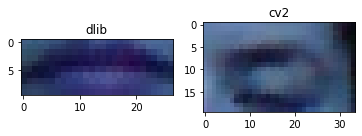

In [6]:
img_path = "MIRACL-VC1/F01/words/01/01/color_001.jpg"
roi_dlib = mouth_detection_dlib(img_path)
roi_cv2 = mouth_detection_cv(img_path)

plt.subplot(1,2,1)
plt.imshow(roi_dlib)
plt.title("dlib")
plt.subplot(1,2,2)
plt.imshow(roi_cv2)
plt.title("cv2")
plt.show()

#### Creation of Cropped Version of the Dataset
Once we have noted that OpenCV has less accuracy than dlib we have chosen
to go on with dlib for creating a new version of each frame that includes only the mouth.

In [7]:
def crop_all():
    for person in tqdm(people, desc='Main', leave=True):
        for data_type in tqdm(data_types, desc='Type', leave=False):
            for enum in tqdm(folder_enum, desc='Label', leave=False):
                for instance in tqdm(instances, desc='Instance', leave=False):
                    path = "../MIRACL-VC1/" + person + "/" + data_type + "/" + enum + "/" + instance
                    images = os.listdir(path)
                    for image in tqdm(images, desc='Frame', leave=False):
                        if image.startswith('color'):
                            file_name = "../MIRACL-VC1/" + person + "/" + \
                                        str(data_type) + "/" + str(enum) + "/" + \
                                        str(instance) + "/" + "cropped_" + str(image)

                            cropped = mouth_detection_dlib(str(path + "/" + str(image)))
                            # UNCOMMENT ME
                            #cv2.imwrite(file_name, cropped)

<div class="alert alert-block alert-warning">
    <b>Warning:</b> This statement can take a long time to execute, in order to see the results I suggest
    to set the test flag to true.
</div>
<br />

If you want to change the flag simply change the value [test](#test-flag)`=True`

In [8]:
#crop_all()